# Parameter sensitivity study - loop 03 results overview


The aim of loop 03 is to determine when probabilistic method (mc) is more appriopriate than the advanced one (adv).

Total 4607 board states were tested, ranging from those having 25 free fields, up to  72 free fields. They were calculated using both methods. Parameters chosen for mc method were [conf_level = 3.29, margin_est = 1.0, margin_highest = 0.06], which is the most accurate out of all considered.

Board states to run were taken from already existing part of the calculation library, which is mostly composed of real game scenarios simulated in main game script.

# Load result files

Load the sensitivity study results file from loop 03.

In [24]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1700)
pd.set_option('display.max_columns', 20)
pd.set_option('max_colwidth', 2000)

param_sens_study_dir = "param_sens_study\\L03"
param_sens_study_file = "param_sens_study_file_mc_or_adv.csv"
param_sens_study_path = os.path.join(param_sens_study_dir, param_sens_study_file)

df = pd.read_csv(param_sens_study_path)

Load 'times_adv' file, which contains data about calculation time using advanced algorithm

In [25]:
times_adv_dir = "times_adv\\"
times_adv_file = "times_adv_file.npy"
times_adv_path = os.path.join(times_adv_dir, times_adv_file)

adv_times_numpy = np.load(times_adv_path)

adv_times_df = pd.DataFrame(adv_times_numpy)
adv_times_df.columns = ['board_state_100chars_code', 'time_adv']
adv_times_df['time_adv'] = adv_times_df['time_adv'].apply(pd.to_numeric, errors='coerce')

print(adv_times_df.sample(5))


                                                                                 board_state_100chars_code  time_adv
1816  0070007370770070737727000073752777777775777227007500777707750777777075074444707707777777770000007333      0.02
560   0077227000000777700777700700707470700700747700700074700777777470773337777707777772277777777777555557      0.03
3679  7777777777372775555537277777773777070074770070077400700070740000070074070000777700000072700000007270      0.07
2401  0707000077707000007401000000740000000074777777777407577333777757777770375707707037577077073757070070      0.42
2263  0077777000007333700777777770705744447700577777700757007000705770000700570777700777072270000077777000      0.27


# Aggregate & Map

##### Aggregate series of repetitive runs for the same board_state and parameters

In [26]:
avg_res = df.groupby(['board_state_100chars_code', 'conf_level', 'margin_est', 'margin_highest'], as_index=False).agg(
    rel_error = ('rel_error', 'mean'),
    time_mc = ('time_mc', 'mean'),
    max_error = ('rel_error', 'max'),
    )
print(avg_res.sample(5))


                                                                                 board_state_100chars_code  conf_level  margin_est  margin_highest  rel_error  time_mc  max_error
276   0000070000000000070000011110777777700072444470707277777000770000070000000000700000000777770000073337        3.29         1.0            0.06        0.0     6.29        0.0
3769  5555570777777777073777700077377470000737747000077774770000007470700010777007070770070070700700700707        3.29         1.0            0.06        0.0    16.53        0.0
669   0000700000777777000055555700007777770000333700000777770000000070000000000070000077777700007444470000        3.29         1.0            0.06        0.0    12.70        0.0
502   0000075700000007570000000757070000075770000007570770000777770007777773000733377300077777730070070077        3.29         1.0            0.06        0.0    15.75        0.0
2411  0075770000107570000717757077700075707470707577747700777074700007007470000077777700007227000000777700    

Next, map advanced calculation time per board state

In [27]:
avg_res['time_adv'] = avg_res['board_state_100chars_code'].map(adv_times_df.set_index('board_state_100chars_code')['time_adv'])

# Relation between board state and time

We can describe the calculation complexity level of a board state by 3 simple metrics: 
1. Number of zeros (free fields, '0')
2. Number of hits (fields containing any value between 1-5)
3. Number of ones (hit unsunk fields '1')



In [28]:
avg_res['n_zeros'] = avg_res['board_state_100chars_code'].apply(lambda x: x.count('0'))
avg_res['n_hits'] = avg_res['board_state_100chars_code'].apply(lambda x: (100 - x.count('0') - x.count('7')))
avg_res['n_ones'] = avg_res['board_state_100chars_code'].apply(lambda x: x.count('1'))
print(avg_res.sample(10))

                                                                                 board_state_100chars_code  conf_level  margin_est  margin_highest  rel_error  time_mc  max_error  time_adv  n_zeros  n_hits  n_ones
1028  0000777777000075555500007777770077773337777277777722727007777777700737700007073700070077370700700777        3.29         1.0            0.06        0.0     2.61        0.0      0.08       33      15       0
2448  0077444470000777777077000070072700070070277777770777555557707777777777227700707377700700730000700773        3.29         1.0            0.06        0.0     2.28        0.0      0.03       34      16       0
3455  2270700000777700000033377770007777737000570073700057007370075700777000570000000057000000007700000000        3.29         1.0            0.06        0.0     9.41        0.0      5.55       56      13       0
158   0000070000000000000000000000000000007000777777000755555707777777777073774444707307777770730070700777        3.29         1.0            0.06  

Now, we can plot a relation between calculation time by both methods and these metrics.

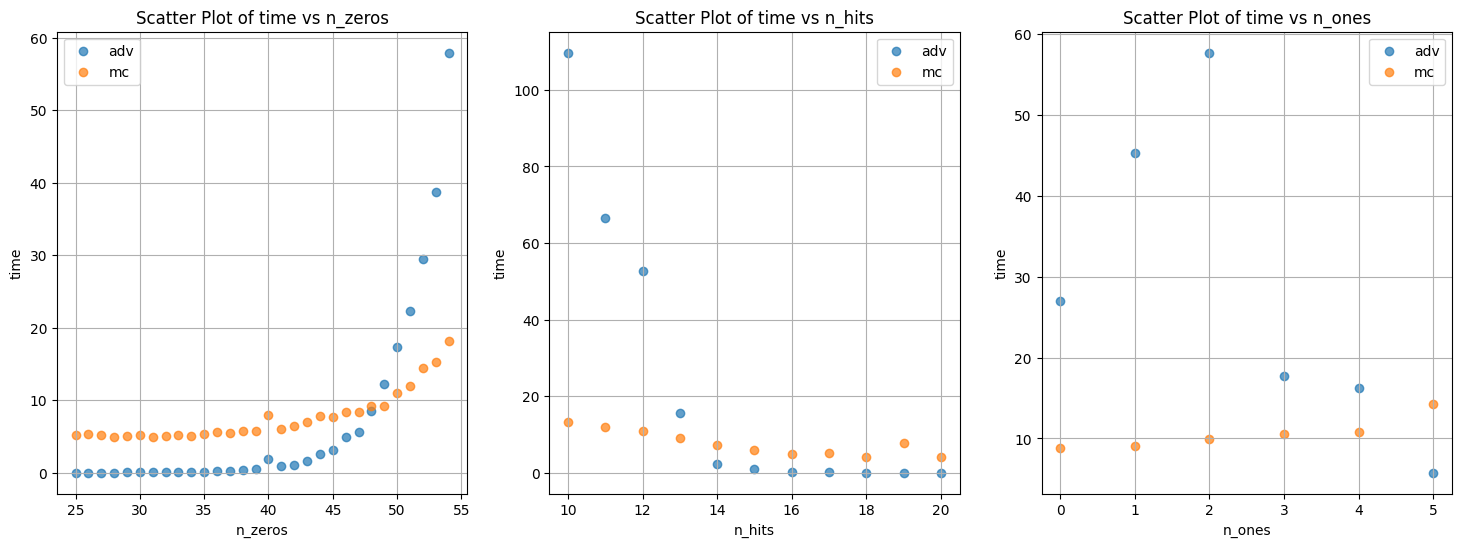

In [29]:
def plot_time_vs_board_state_stats(avg_res):

    n_zeros_plot = avg_res.groupby('n_zeros', as_index = False).agg(
        time_adv_avg = ('time_adv', 'mean'),
        time_mc_avg = ('time_mc', 'mean')
    )
    n_zeros_plot = n_zeros_plot.query('n_zeros < 55')

    n_hits_plot = avg_res.groupby('n_hits', as_index = False).agg(
        time_adv_avg = ('time_adv', 'mean'),
        time_mc_avg = ('time_mc', 'mean')
    )
    n_hits_plot = n_hits_plot.query('n_hits > 9')

    n_ones_plot = avg_res.groupby('n_ones', as_index = False).agg(
        time_adv_avg = ('time_adv', 'mean'),
        time_mc_avg = ('time_mc', 'mean')
    )

    # Scatter plot
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    # plt.figure(figsize=(8, 6))
    plt.scatter(n_zeros_plot.n_zeros, n_zeros_plot.time_adv_avg, alpha=0.7, label = 'adv')
    plt.scatter(n_zeros_plot.n_zeros, n_zeros_plot.time_mc_avg, alpha=0.7, label = 'mc')
    plt.xlabel('n_zeros')
    plt.ylabel('time')
    plt.title('Scatter Plot of time vs n_zeros')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 3, 2)
    # plt.figure(figsize=(8, 6))
    plt.scatter(n_hits_plot.n_hits, n_hits_plot.time_adv_avg, alpha=0.7, label = 'adv')
    plt.scatter(n_hits_plot.n_hits, n_hits_plot.time_mc_avg, alpha=0.7, label = 'mc')
    plt.xlabel('n_hits')
    plt.ylabel('time')
    plt.title('Scatter Plot of time vs n_hits')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 3, 3)
    # plt.figure(figsize=(8, 6))
    plt.scatter(n_ones_plot.n_ones, n_ones_plot.time_adv_avg, alpha=0.7, label = 'adv')
    plt.scatter(n_ones_plot.n_ones, n_ones_plot.time_mc_avg, alpha=0.7, label = 'mc')
    plt.xlabel('n_ones')
    plt.ylabel('time')
    plt.title('Scatter Plot of time vs n_ones')
    plt.grid(True)
    plt.legend()

    plt.show()

plot_time_vs_board_state_stats(avg_res)

And we got beautiful exponential curves. 

But before we comment more, let's investigate one anomaly happening at exactly n_zeros = 40. It's not game-changing by any means, but just hurts my eyes.

In [30]:
n_zeros_40 = avg_res.query("n_zeros == 40")
#print(n_zeros_40)
print(n_zeros_40.describe())   

print(n_zeros_40.query("time_mc > 200"))

         conf_level  margin_est  margin_highest   rel_error     time_mc   max_error    time_adv  n_zeros      n_hits     n_ones
count  1.200000e+02       120.0    1.200000e+02  120.000000  120.000000  120.000000  119.000000    120.0  120.000000  120.00000
mean   3.290000e+00         1.0    6.000000e-02    0.000517    7.980667    0.000517    1.853866     40.0   14.616667    0.40000
std    4.459512e-16         0.0    2.787195e-17    0.002417   20.282642    0.002417   13.339618      0.0    1.473482    0.71479
min    3.290000e+00         1.0    6.000000e-02    0.000000    0.050000    0.000000    0.040000     40.0    8.000000    0.00000
25%    3.290000e+00         1.0    6.000000e-02    0.000000    4.930000    0.000000    0.100000     40.0   14.000000    0.00000
50%    3.290000e+00         1.0    6.000000e-02    0.000000    5.950000    0.000000    0.370000     40.0   15.000000    0.00000
75%    3.290000e+00         1.0    6.000000e-02    0.000000    7.380000    0.000000    0.820000     40.0

A time_mc value of 226 stands out, which is a result of following board state:


In [31]:
k = '5555577333777777777777777777777777777777777777777777777777770000000000000000000000000000000000000000'
matrix = np.zeros(100)
for n in range(0,100):
    matrix[n] = str(k[n])
matrix = np.array(matrix.reshape(10,10), dtype='int16')

print(np.array2string(matrix, separator=', '))

[[5, 5, 5, 5, 5, 7, 7, 3, 3, 3],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]



This one was some manually defined test, not a real game scenario. This is never supposed to happen, so we can safely exclude it from statistics and generate the plots again.

Also, let's fit some exponential curves so it looks fancier.

In [36]:
avg_res_cleaned = avg_res.query('board_state_100chars_code != "5555577333777777777777777777777777777777777777777777777777770000000000000000000000000000000000000000"')

from scipy.optimize import curve_fit

def plot_time_vs_board_state_stats_with_fit(avg_res):

    n_zeros_plot = avg_res.groupby('n_zeros', as_index = False).agg(
        time_adv_avg = ('time_adv', 'mean'),
        time_mc_avg = ('time_mc', 'mean')
    )
    n_zeros_plot = n_zeros_plot.query('n_zeros < 55')

    n_hits_plot = avg_res.groupby('n_hits', as_index = False).agg(
        time_adv_avg = ('time_adv', 'mean'),
        time_mc_avg = ('time_mc', 'mean')
    )
    n_hits_plot = n_hits_plot.query('n_hits > 9')

    n_ones_plot = avg_res.groupby('n_ones', as_index = False).agg(
        time_adv_avg = ('time_adv', 'mean'),
        time_mc_avg = ('time_mc', 'mean')
    )

    # Scatter plot
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 2)
    # plt.figure(figsize=(8, 6))
    plt.scatter(n_hits_plot.n_hits, n_hits_plot.time_adv_avg, label = 'adv')
    plt.scatter(n_hits_plot.n_hits, n_hits_plot.time_mc_avg, label = 'mc')
    plt.xlabel('n_hits')
    plt.ylabel('time')
    plt.title('Scatter Plot of time vs n_hits')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 3, 3)
    # plt.figure(figsize=(8, 6))
    plt.scatter(n_ones_plot.n_ones, n_ones_plot.time_adv_avg, label = 'adv')
    plt.scatter(n_ones_plot.n_ones, n_ones_plot.time_mc_avg, label = 'mc')
    plt.xlabel('n_ones')
    plt.ylabel('time')
    plt.title('Scatter Plot of time vs n_ones')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 3, 1)
    # plt.figure(figsize=(8, 6))
    plt.scatter(n_zeros_plot.n_zeros, n_zeros_plot.time_adv_avg, label = 'adv')
    plt.scatter(n_zeros_plot.n_zeros, n_zeros_plot.time_mc_avg, label = 'mc')

    # Fit mc exponential curve
    x = n_zeros_plot.n_zeros
    y = n_zeros_plot.time_mc_avg
    a_guess = 0.15
    b_guess = 0.1
    c_guess = 4
    popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(b * t) + c, x, y, p0=(a_guess, b_guess, c_guess))
    a = popt[0]
    b = popt[1]
    c = popt[2]
    x_fitted_mc = np.linspace(np.min(x), np.max(x), 100)
    y_fitted_mc = a * np.exp(b * x_fitted_mc) + c
    plt.plot(x_fitted_mc, y_fitted_mc, color='red', label='mc_fitted')

    # Fit adv exponential curve
    x = n_zeros_plot.n_zeros
    y = n_zeros_plot.time_adv_avg
    a_guess = 0.15
    b_guess = 0.1
    c_guess = 4
    popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(b * t) + c, x, y, p0=(a_guess, b_guess, c_guess))
    a = popt[0]
    b = popt[1]
    c = popt[2]
    x_fitted_adv = np.linspace(np.min(x), np.max(x), 100)
    y_fitted_adv = a * np.exp(b * x_fitted_adv) + c
    plt.plot(x_fitted_adv, y_fitted_adv, color='darkblue', label='adv_fitted')

    plt.xlabel('n_zeros')
    plt.ylabel('time')
    plt.title('Scatter Plot of time vs n_zeros')
    plt.grid(True)
    plt.legend()

    plt.show()

plot_time_vs_board_state_stats_with_fit(avg_res_cleaned)

Way better now.

Could do the same for n_hits plot, but n_zeros seems more suited for a main determining factor.

The lines intersect at n_zeros = 48, so until that point, on average, it makes more sense to go with advanced method, because it's faster and 100% accurate.

Let us investigate if above that number of zeros there are any 'special cases' where it is stil benficial to use adv instead of mc method, for example depending on number of hits. To do that, we group the data by combinations of [n_zeros, n_hits]. 

We also add an auxiliary column with time_adv / time_mc ratio. Let's assume that the ratio of 2.0 will be the boundary between suitability for adv / mc methods. Since this is a matter of additionally up to 10 seconds, I can tolerate twice as long calculation if it then gets 100% accurate.

Printed output is limited to the n_zeros range between 45-55, which is the part we are mostly focused on.



In [33]:
by_board_state_stats = avg_res.groupby(['n_zeros', 'n_hits'], as_index=True).agg(
    avg_time_adv = ('time_adv', 'mean'),
    avg_time_mc = ('time_mc', 'mean'),
    count = ('board_state_100chars_code', 'count'),
)
by_board_state_stats['adv_to_mc_ratio'] = by_board_state_stats['avg_time_adv'] / by_board_state_stats['avg_time_mc']
adv_suited = by_board_state_stats.query("adv_to_mc_ratio < 2")
adv_suited = adv_suited.query("n_zeros > 45")

print("adv_suited:")
print(adv_suited, "\n")

mc_suited = by_board_state_stats.query("adv_to_mc_ratio >= 2")
mc_suited = mc_suited.query("n_zeros < 56")

print("mcsuited:")
print(mc_suited)

adv_suited:
                avg_time_adv  avg_time_mc  count  adv_to_mc_ratio
n_zeros n_hits                                                   
46      9           7.195000    19.795000      2         0.363476
        10          0.732500     7.792500      4         0.094001
        11          3.896000     7.726000     10         0.504271
        12         12.733548     9.353548     31         1.361360
        13          5.543571     8.978571     28         0.617422
        14          1.908936     7.896596     47         0.241742
        15          1.376818     6.827727     22         0.201651
        16          1.090000     8.417500      4         0.129492
47      10          3.401111     7.834444      9         0.434123
        11          6.650000    10.947333     15         0.607454
        12         11.979697     8.203333     33         1.460345
        13          8.280000     7.902000     20         1.047836
        14          1.956226     7.979434     53         0.24515

We can see that n_zeros = (48, 49, 50) exceed the acceptable adv_to_mc_ratio only for n_hits = 12, which is probably related to one special game scenario. The ratio is also not super high in those cases and way lower than 2.0 for other number of hits, so I think it's overall worth to consider n_zeros = 50 as suitable for advanced method.

Above 50 there still are cases where adv is mostly faster than mc, but we are starting to see more and more exceptions, so let's give up on that and stick to the boundary of 50.

# Summary and conclusions



Conclusions on what to do in next loop of this study:
1. Gather mc calculation data only for board states with n_zeros > 50
2. From already obtained Loop 02 results, remove entries for board states with n_zeros <= 50. They might carry some information, but it's eventually irrelevant for the actual goal of the study. These scenarios will not be calculated with mc method, so they must not influence the averaged results upon which we determine optimal paramaters for mc calculation.